In [1]:
import os
import random
import math

%matplotlib inline
import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [3]:
class_label = 1
class_dict = dict()
reverse_class_dict = []
reverse_class_dict.append((-100, -100))
for i in range(400, 800, 50):
    for j in range(100, 700, 50):
        top_right_corner = (i+50, j)
        bottom_right_corner = (i+50, j+50)
        
        v1 = np.array([bottom_right_corner[0] - 400, 800 - bottom_right_corner[1] - 400])
        v3 = np.array([top_right_corner[0] - 400, 800 - top_right_corner[1] - 400])
        v2 = np.array([2, 0])
        
        if abs(angle_between(v1, v2)) <= 35 or abs(angle_between(v3, v2)) <= 35:
            class_dict[(i, j)] = class_label
            class_label += 1
            reverse_class_dict.append((i, j))
        else:
            continue
        
class_dict[(-100, -100)] = 0

In [4]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [456]:
def front_collate_fn(batch):
    front_imgs = []
    target = []
    road_imgs = []
    bbs = []
    flips = []
    for x in batch:
        # input
        flip_flag = False
        # Flipping with probability 0.5
        if np.random.choice([0, 1]):
            flip_flag = True
            flips.append(True)
            img = x[0][1].numpy()
            flipped_img = np.fliplr(img.transpose(1, 2, 0)).transpose(2, 0, 1)
            front_imgs.append(torch.as_tensor(flipped_img.copy()))
        else:
            front_imgs.append(torch.tensor(x[0][1]))
            flips.append(False)
        
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins = np.zeros(59)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # Get the top of the bounding box (top-center) point. Covers the edge case when the top of the car
            # is peeking into the image, but we can't . ...Although...
            # If we can only see the top part of the car, that means there's another view that 
            # has a much bigger slice of it, and can capture it. 
            # So I actually don't need to do this. And it will prob be helpful,
            # because why make this view try very hard to learn this, when another view can handle it just fine. 
            # Eh, I'll focus on this later. I just want to get this working for now. 
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                current_bbs.append((xs, ys))
                # we're in the bucket of the front_img
                if flip_flag:
                    # vertically flip where the top_center coordinates of the bounding box are. 
                    top_of_car = (top_center_x.item(), 800 - top_center_y.item())
                else:
                    top_of_car = (top_center_x.item(), top_center_y.item())
                key = (round_down(top_of_car[0]), round_down(top_of_car[1]))
                if key not in class_dict:
                    print(key)
                bin_id = class_dict[key]
                bins[bin_id] = 1
                
        target.append(torch.as_tensor(bins))
        bbs.append(current_bbs)
                
    boom = torch.stack(front_imgs), torch.stack(target), torch.stack(road_imgs), bbs, flips
    return boom

In [457]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.Grayscale(3),
#         transforms.RandomAffine(5),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [459]:
sample, target, road_img, bbs, flips = iter(train_loader).next()

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [460]:
idx = -1

In [461]:
idx += 1

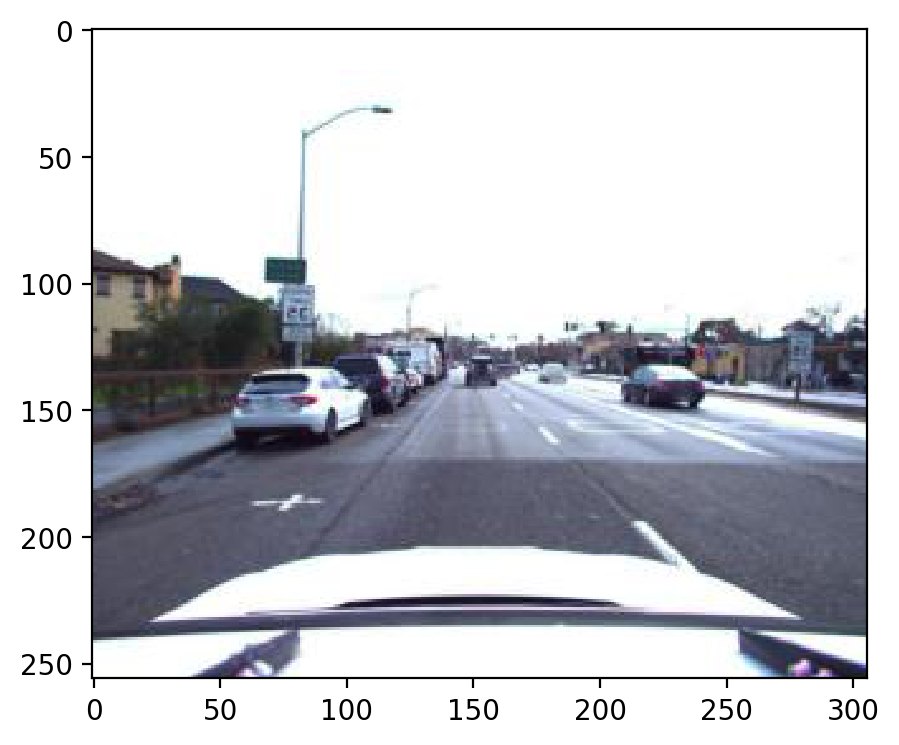

In [468]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

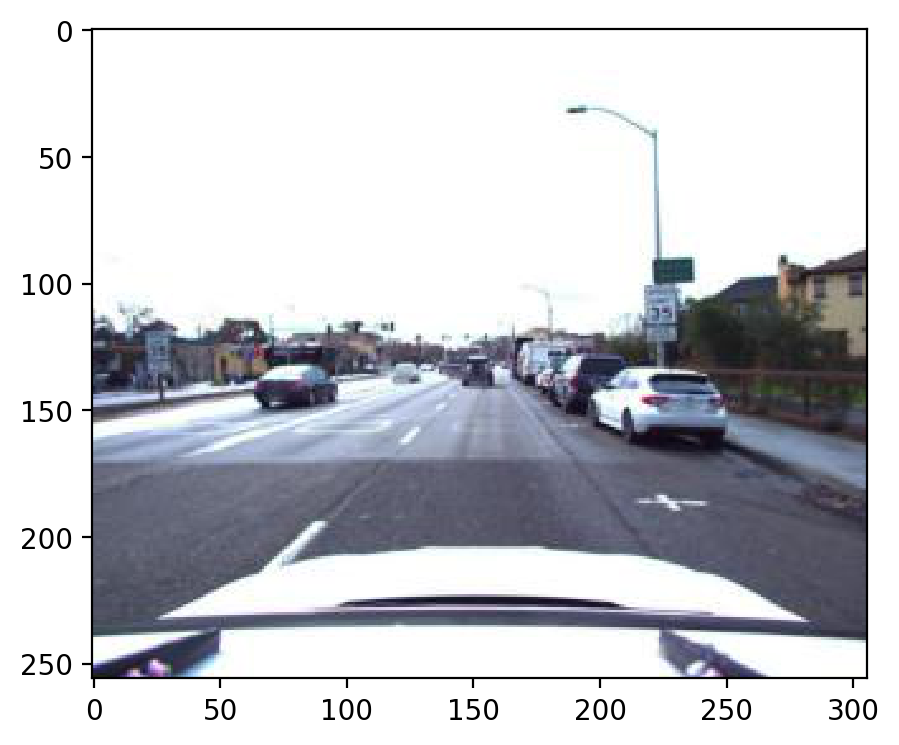

In [467]:
plt.imshow(np.fliplr(sample[idx].cpu().detach().numpy().transpose(1, 2, 0)))

In [465]:
print(flips[idx])

True


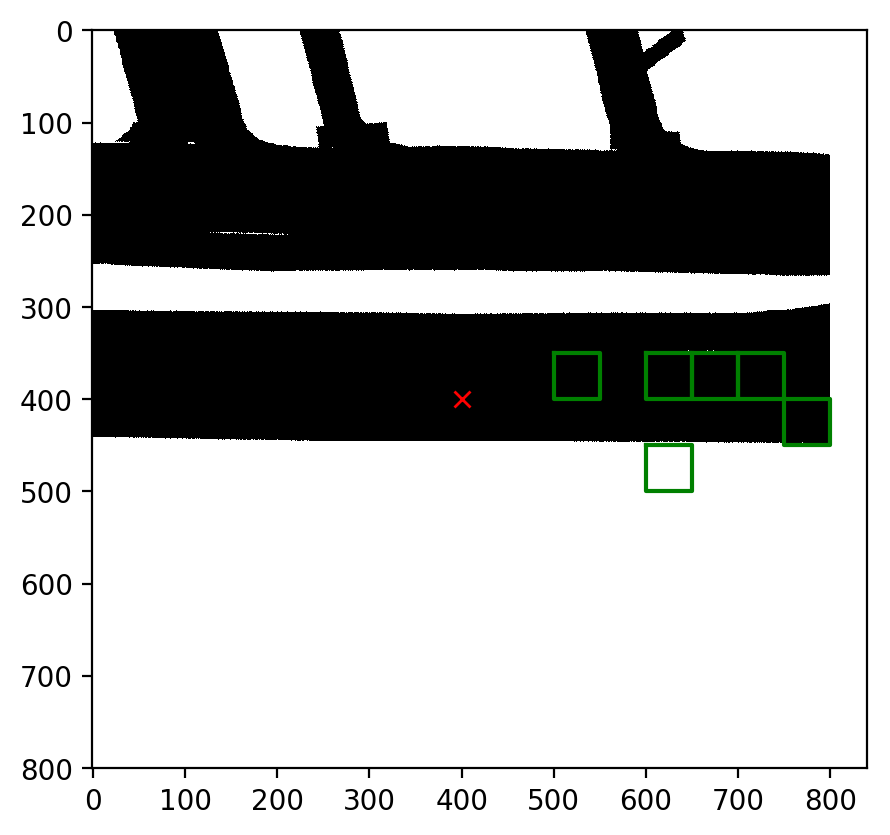

In [466]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    
    draw_box(ax, class_box, 'green')

In [5]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    counts = []
    for x in batch:
        # input
        front_left_imgs.append(torch.as_tensor(x[0][0]))
        front_imgs.append(torch.as_tensor(x[0][1]))
        front_right_imgs.append(torch.as_tensor(x[0][2]))
        road_imgs.append(torch.as_tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins = np.zeros(59)
        count = 0
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # Get the top of the bounding box (top-center) point. Covers the edge case when the top of the car
            # is peeking into the image, but we can't . ...Although...
            # If we can only see the top part of the car, that means there's another view that 
            # has a much bigger slice of it, and can capture it. 
            # So I actually don't need to do this. And it will prob be helpful,
            # because why make this view try very hard to learn this, when another view can handle it just fine. 
            # Eh, I'll focus on this later. I just want to get this working for now. 
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                current_bbs.append((xs, ys))
                # we're in the bucket of the front_img
                top_of_car = (top_center_x.item(), top_center_y.item())
                key = (round_down(top_of_car[0]), round_down(top_of_car[1]))
                if key not in class_dict:
                    print(key)
                bin_id = class_dict[key]
                bins[bin_id] = 1
                count += 1
                
        target.append(torch.as_tensor(bins))
        counts.append(count)
        bbs.append(current_bbs)
                
    boom = torch.stack(front_imgs), torch.stack(target), torch.stack(road_imgs), bbs, torch.as_tensor(counts)
    return boom

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.Grayscale(3),
#         transforms.RandomAffine(5),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet50()
        self.encoder.fc = nn.Identity()
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(2048, 59)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(2048, 20))
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.classification(x)

In [8]:
model = SimpleModel()
device = torch.device('cpu')
model.load_state_dict(torch.load('best_val_loss_class_counts_flip.pt', map_location=device))

<All keys matched successfully>

In [9]:
sample, target, road_img, bbs, _ = iter(val_loader).next()
sample = sample.to(device)
model_preds = model(sample)

In [10]:
idx = -1

In [187]:
idx += 1

In [188]:
# If I can do np.fliplr, we got twice as much data from that. 
# Like 3000 --> 6000. And we got the labels for it too. 
# So what do I have to do? 
# All right so I refresh the dataset/dataloader every epoch. 
# So we're good on that end. 
# Okay so in the collate_fn...
# for x in batch:

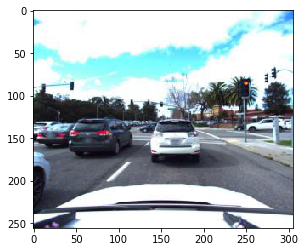

In [189]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

In [190]:
# plt.imshow(np.fliplr(sample[idx].cpu().detach().numpy().transpose(1, 2, 0)))

In [191]:
def draw_box(ax, class_box, color):
    box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50, class_box[0]]
    box_ys = [class_box[1], class_box[1]+50, class_box[1]+50, class_box[1], class_box[1]]
    ax.plot(box_xs, box_ys, color=color)

In [192]:
model_preds.shape

torch.Size([32, 59])

In [193]:
sigmoid_preds = torch.sigmoid(model_preds[idx])
sigmoid_preds

tensor([2.2933e-04, 1.0111e-02, 5.0889e-03, 3.4006e-03, 1.1670e-01, 1.9627e-02,
        2.6545e-03, 6.8642e-04, 5.7784e-02, 7.6000e-01, 2.3454e-01, 7.6876e-02,
        1.0838e-03, 4.2655e-02, 2.7503e-02, 1.2098e-01, 2.2124e-02, 4.2973e-02,
        3.9368e-02, 1.4692e-02, 1.9015e-01, 1.3695e-02, 3.9212e-02, 1.1259e-02,
        2.9092e-02, 8.0208e-02, 9.8317e-03, 2.8070e-03, 3.3745e-02, 1.2918e-01,
        2.9731e-02, 5.6810e-02, 8.3199e-03, 3.8394e-02, 1.4360e-01, 6.5986e-02,
        2.7247e-03, 2.1277e-02, 6.5224e-02, 1.0836e-01, 3.4617e-02, 1.1309e-01,
        6.7440e-02, 2.7660e-02, 1.0425e-01, 8.7799e-02, 2.2090e-02, 2.2472e-02,
        3.7196e-02, 6.8774e-02, 6.9057e-02, 2.5072e-02, 9.5030e-02, 5.4591e-02,
        4.3098e-02, 7.6863e-02, 8.3043e-02, 6.0871e-02, 2.5941e-02],
       grad_fn=<SigmoidBackward>)

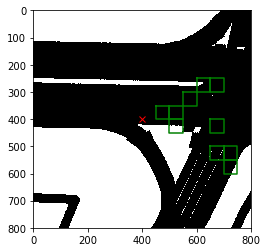

In [194]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    
    draw_box(ax, class_box, 'green')

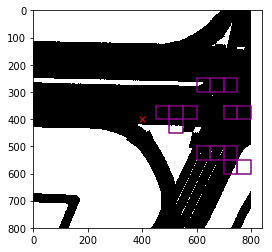

In [195]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

bin_ids = (sigmoid_preds > 0.08).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    draw_box(ax, class_box, 'purple')

In [196]:
(600 - 400, 800 - 300 - 400)

(200, 100)

In [158]:
(400, 400) + (200, -100)

(400, 400, 200, -100)

In [147]:
(600, 300)

(600, 300)

In [115]:
(600, 800 - 300)

(600, 500)